In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

from scipy.optimize import minimize
from scipy.special import binom
from scipy.stats import multivariate_normal

In [2]:
plt.rc('axes', labelsize=14)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=12)    # fontsize of the tick labels
plt.rc('ytick', labelsize=12)    # fontsize of the tick labels
plt.rc('legend', fontsize=14)    # legend fontsize

# Rats laboratory experiment

This experiment involves $m=6$ rats that are given different doses of a certain drug.
The doses are given by

$$
x_i = \frac{i}{5} \,\,\,\,\, \text{for} \,\,\, i=1,\ldots,10
$$

and the occurrences of a certain event $A$ are given by

$$
y = [2, 1, 2, 2, 3, 4, 1, 2, 5, 3].
$$

So we have ten binomial experiments
$
y_j \sim \text{Bin}(m, p_j)
$
where the probabilities are modelled using the **logistic regression** model

$$
p_j = \mathbb{P}(A \,|\, x_j) = H(a + b x_j)
$$

with $H(u) = e^u \,/\, (1 + e^u)$ being the logistic (or sigmoid) curve.

In [3]:
def sigmoid(x):
    return np.where(
        x >= 0, 1 / (1 + np.exp(-x)), np.exp(x) / (1 + np.exp(x))
    )

In [4]:
m = 6
doses = np.linspace(0.2, 2.0, 10, endpoint=True)
events = np.array([2, 1, 2, 2, 3, 4, 1, 2, 5, 3])

p = lambda a, b: sigmoid(a + b * doses)

## Maximum likelihood estimation

In order to give an initial estimation of the unknowns $a, b$, we set up the likelihood function

$$
L(a, b) = \prod_{j=1}^{10} {m \choose y_j} p_j^{y_j} (1 - p_j)^{m - y_j}.
$$

Further, taking the logarithm yields the log-likelihood

$$
l(a, b) = \sum_{j=1}^{10} \log {m \choose y_j} + y_j \log p_j + (m-y_j) \log (1-p_j).
$$

__Note:__ The parameters $a, b$ are hidden in $p_j = p_j(a, b)$.

In [5]:
def log_lik(params):
    a, b = params
    return -np.sum(
        np.log(binom(m, events)) + events * np.log(p(a, b)) + (m - events) * np.log(1 - p(a, b))
    )

In [6]:
# Minimze.
res = minimize(log_lik, np.array([1., 1.]))
a_ml, b_ml = res.x
print(f"ML: a = {a_ml:.3f}, b = {b_ml:.3f}")

ML: a = -1.173, b = 0.747


The prediction for doses $x \in [0, 2.5]$ with this model $p_{ML}$, as well as the data points $(x_j, y_j)$ can be seen below. We observe a positive trend in the data, and the model $p_{ML}$ looks almost linear, rather than sigmoidal.

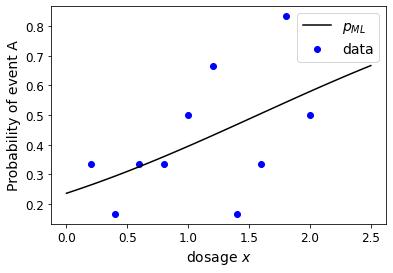

In [7]:
x = np.linspace(0, 2.5, 100)

plt.plot(x, sigmoid(a_ml + b_ml * x), "k", label=r"$p_{ML}$")
plt.scatter(doses, events / m, c="b", label="data")
plt.ylabel("Probability of event A")
plt.xlabel(r"dosage $x$")
plt.legend();

## Markov Chain Monte Carlo (MCMC)

We use a flat prior for $(a,b)$ on $[-8, 8] \times [-8, 8]$ and set up a MCMC procedure by

$$
p_{i+1} =
\begin{cases} 
      p_i + \delta n_i, & \text{with prob} \,\, r_i \\
      p_i, & \text{with prob} \,\,(1 - r_i),
\end{cases}
$$

where $\delta > 0$, $p_i = (a_i,\, b_i)^\top$, $n_i \sim N_2(0, I)$ and

$$
r_i = \min \left\{1, \frac{f(p_i + \delta n_i)}{f(p_i)}\right\}
$$

is the probability of acceptance. The function $f$ is the so-called target distribution. The parameter $\delta$ must be chosen well, it must not be too large and not too small. If $\delta$ is too large, the parameters change too quickly and there is no convergence.

In [8]:
def MCMC(f, delta, sim):
    """ Markov Chain Monte Carlo
    params:
    -------
    - f: target function, [Callable]
    - delta: exploition, [float]
    - sim: number of simulations [int]
    """
    mcmc = np.zeros((sim, 2))

    u = np.random.uniform(size=sim)
    v = multivariate_normal.rvs(
        mean=None,
        cov=np.eye(2),
        size=sim
    )
    pracc = np.zeros(sim)
    ok = np.zeros(sim)
    mcmc[0] = np.array([-1, 1])

    for ss in range(sim - 1):
        old = mcmc[ss]
        prop = old + delta * v[ss]

        pracc[ss] = min(
            1,
            np.exp(
                np.log(f(prop)) - np.log(f(old))
            ))
        ok[ss] = u[ss] <= pracc[ss]
        mcmc[ss + 1] = (
            ok[ss] * prop + (1 - ok[ss]) * old
        )

    return mcmc, pracc, ok

In [9]:
target = lambda params: np.exp(-log_lik(params) - 2 * np.log(16))
delta = .1
n_sim = 10 ** 4

mcmc, pracc, ok = MCMC(target, delta, n_sim)
print(f"Acceptance rate: {pracc.mean():.3f}")

Acceptance rate: 0.808


### Lazy Bayesian approach

Another common way to sample is to utilize the normal approximation

$$
N_2(p_{ML},\, \Sigma_{ML})
$$

with $p_{ML} = (a_{ML}, \, b_{ML})^\top$ and the observed Fisher information matrix

$$
\Sigma_{ML} = \left(\frac{\partial^2}{\partial^2 p^2} l(a_{ML},\,b_{ML})\right)^{-1}.
$$

The comparison between the samples of the two methods MCMC and Lazy Bayesian are shown down below. Red lines show the corresponding mean values.

In [10]:
lazy = multivariate_normal.rvs(
    mean=res.x,
    cov=res.hess_inv,
    size=n_sim,
)

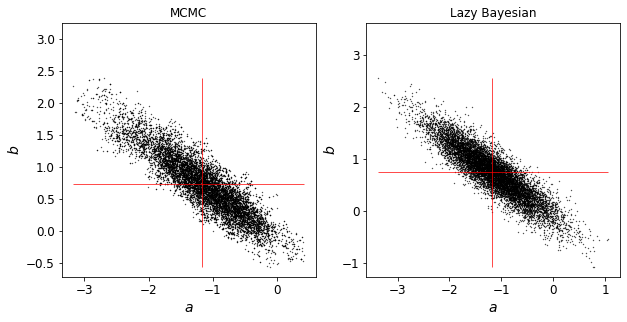

In [11]:
fig = plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(*mcmc.T, s=.1, c="k")
plt.hlines(mcmc.mean(0)[1], mcmc.min(0)[0], mcmc.max(0)[0], colors="r", lw=1., alpha=.7)
plt.vlines(mcmc.mean(0)[0], mcmc.min(0)[1], mcmc.max(0)[1], colors="r", lw=1., alpha=.7)
plt.xlabel(r"$a$")
plt.ylabel(r"$b$")
plt.title("MCMC")
plt.axis("square")

plt.subplot(1, 2, 2)
plt.scatter(*lazy.T, s=.1, c="k")
plt.hlines(lazy.mean(0)[1], lazy.min(0)[0], lazy.max(0)[0], colors="r", lw=1., alpha=.7)
plt.vlines(lazy.mean(0)[0], lazy.min(0)[1], lazy.max(0)[1], colors="r", lw=1., alpha=.7)
plt.xlabel(r"$a$")
plt.ylabel(r"$b$")
plt.title("Lazy Bayesian")
plt.axis("square");

One can also see the mean values for the parameters $a$ and $b$ plotted as red lines, which do not differ greatly between the two methods.

## Credibility band

A 90\% credibility band for $p$ is now constructed. To do this, we use the data from the MCMC simulation and calculate the prediction for each dosage x and for each parameter constellation $(a_i, b_i)$ for $i=1,\ldots,N_{SIM}$. Then, $\text{low}(x)$ and $\text{up}(x)$ are given by the $0.05$ and $0.95$ quantile for the dosage $x$, respectively.

Thus given some dose $x > 0$, the probability of event $A$ lies in the band with **90\% probability**, that is

$$
\mathbb{P} (A \,|\, x) \,\in\, [\text{low}(x), \text{up}(x)].
$$

In [12]:
q = np.zeros((x.size, 2))
for i, dosis in enumerate(x):
    q[i] = np.quantile(
        sigmoid(mcmc[:, 0] + mcmc[:, 1] * dosis),
        [0.05, 0.95],
    )

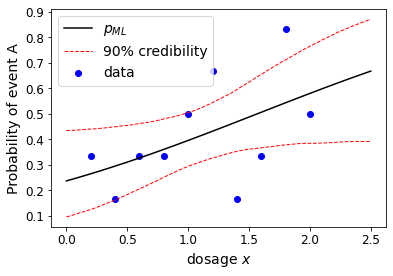

In [13]:
plt.plot(x, sigmoid(a_ml + b_ml * x), "k", label=r"$p_{ML}$")
plt.plot(x, q, "r--", lw=1., label=["90% credibility", None])
plt.scatter(doses, events / m, c="b", label="data")
plt.ylabel("Probability of event A")
plt.xlabel(r"dosage $x$")
plt.legend();

## Posterior distribution of $\mathbb{P}(A\,|\,x_{new})$


Given the dosage $x_{new} = 2.50$ what is the probability of the event A?
Now we use the MCMC samples to create a histogram as an approximation to the posterior distribution of $p(x_{new}) = \mathbb{P}(A\,|\,x_{new})$.

In [14]:
x_new = 2.50
p_sim = sigmoid(mcmc[:, 0] + mcmc[:, 1] * x_new)
q = np.quantile(p_sim, [0.05, 0.50, 0.95])

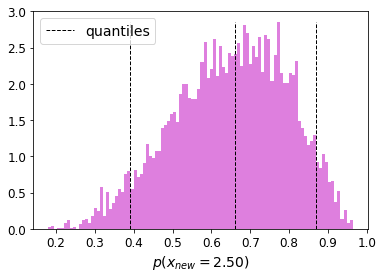

In [15]:
c, _, _ = plt.hist(p_sim, bins=100, density=True, color="m", alpha=.5)
plt.vlines(q, 0, c.max(), colors="k", linestyles="dashed", lw=1., label="quantiles")
plt.xlabel(r"$p(x_{new}=2.50)$")
plt.legend();

## Predictive distribution for $y_{new}$

What is the distribution out of the $m=6$ rats that experience event $A$ when given the dose $x_{new} = 2.50$? In addition to finding the posterior distribution for $p(x_{new})$ above, we are interested in the predictive distribution for 

$$
y_{new} \sim \text{Bin}(m, p(x_{new})).
$$

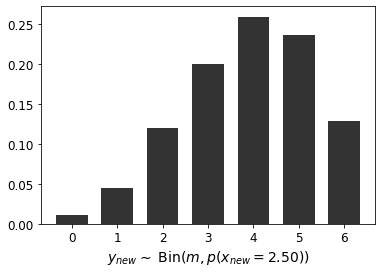

In [16]:
y_sim = stats.binom.rvs(m, p_sim)
plt.bar(np.arange(m + 1), np.bincount(y_sim) / n_sim, width=.7, color="k", alpha=.8)
plt.xlabel(r"$y_{new} \sim$ Bin$(m, p(x_{new}=2.50))$");

## The lethal dose 50% parameter (LD50)

Now we turn to the final parameter $x_{LD50}$ which indicates the dosage $x$ at which 50% of the subjects are **expected** to experience event A.
For fixed model parameters $(a,b)$ it is easy to see that the lethal dose 50% parameter is given by

$$
p(x) = H(a + bx) \overset{!}{=} 0.5 \iff x_{LD50} = - b \,/\, a.
$$

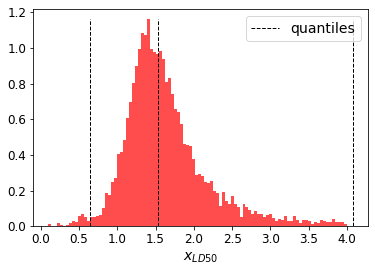

In [17]:
ld50 = -mcmc[:, 0] / mcmc[:, 1]
q = np.quantile(np.array(ld50), [0.05, 0.5, 0.95])

c, _, _, = plt.hist(ld50, range=(0.1, 4), bins=100, density=True, color="r", alpha=.7)
plt.vlines(q, 0, c.max(), color="k", linestyles="dashed", lw=1, label="quantiles")
plt.xlabel(r"$x_{LD50}$")
plt.legend();